# Haldane model: anomalous Hall and shift current

## 1. Define a model with the pythTB package

In [ ]:
import numpy as np

def Haldane_ptb(delta=0.2, hop1=-1.0, hop2=0.15, phi=np.pi / 2):
    """Defines a Haldane model within `PythTB <https://www.physics.rutgers.edu/pythtb/>`__

    Parameters
    -----------
    delta : float
        difference between the on-site potentials of the two atoms
    t : float
        nearest-neighbour hopping
    hop2 : float
        magnitude of next nearest-neighbour hopping
    phi : float
        phase of next nearest-neighbour hopping

    Notes
    -----
    PythTB should be installed to use this (`pip install pythtb`)
    """
    import pythtb
    lat = [[1.0, 0.0], [0.5, np.sqrt(3.0) / 2.0]]
    orb = [[1. / 3., 1. / 3.], [2. / 3., 2. / 3.]]

    my_model = pythtb.tb_model(2, 2, lat, orb)

    delta = 0.2
    t2 = hop2 * np.exp(1.j * phi)
    t2c = t2.conjugate()

    my_model.set_onsite([-delta, delta])
    my_model.set_hop(hop1, 0, 1, [0, 0])
    my_model.set_hop(hop1, 1, 0, [1, 0])
    my_model.set_hop(hop1, 1, 0, [0, 1])
    my_model.set_hop(t2, 0, 0, [1, 0])
    my_model.set_hop(t2, 1, 1, [1, -1])
    my_model.set_hop(t2, 1, 1, [0, 1])
    my_model.set_hop(t2c, 1, 1, [1, 0])
    my_model.set_hop(t2c, 0, 0, [1, -1])
    my_model.set_hop(t2c, 0, 0, [0, 1])

    return my_model


## 2. Calculate the bandstructure for Trivial and topological Haldane models

### a. pythTB model

First we create model as a pythtb object. 

### b. System

Then we turn the model into a WannierBerri System object. After that, WB can work with the system, without caring where it came from (tight-binding or Wannier)

### c. point group symmetry

We also may tell which symmetries this model respects (just provide the generators of the point group). We specify C3z, and for phi=0 (trivial phase) also Time-reversal is respected. 
Note: if Wannier functions were obtained in symmetry-adapted mode, we do not need this step, because the information on the spacegroup is alredy knows

### d. Path

We define a pathalong which to calculate the bands

### e. evaluate_k_path

### f. plot

In [ ]:
from wannierberri.system import System_PythTB
from wannierberri.models import Haldane_ptb
from wannierberri import Path, evaluate_k_path


model_haldane_triv = Haldane_ptb (delta = -0.05, hop1 = -0.4, hop2 = 0.06, phi=0)
model_haldane_topo = Haldane_ptb (delta = -0.05, hop1 = -0.4, hop2 = 0.08, phi=np.pi/3)


system_haldane_topo = System_PythTB(model_haldane_topo)
system_haldane_triv = System_PythTB(model_haldane_triv)

system_haldane_topo.set_pointgroup(["C3z"])
system_haldane_triv.set_pointgroup(["C3z", "TimeReversal"])


path = Path(system = system_haldane_triv, nodes = [[0,0,0], [2/3,1/3,0],[1/2,0,0], [0,0,0],
                                                   [-2/3,-1/3,0], [-1/2,0,0], [0,0,0]]
                                                
            , labels = ['$\Gamma$', '$K$', '$M$', '$\Gamma$', '$K\'$', '$M\'$', '$\Gamma$'],
                   length = 300)

bands_triv = evaluate_k_path(system_haldane_triv, path=path)
bands_topo = evaluate_k_path(system_haldane_topo, path=path)
import matplotlib.pyplot as plt
bands_triv.plot_path_fat(path=path, label='trivial' ,close_fig=False, show_fig=False , Emin=-2, Emax=2, linecolor='blue')
bands_topo.plot_path_fat(path=path, label='topological',close_fig=False, show_fig=False, Emin=-2, Emax=2, linecolor='red')
plt.grid()
plt.show()



## 3. DOS, AHC, shift current

To do an integration over a grid we need 3 thing more :

### a. Grid

### b. calculator

### c. run()

In [ ]:
from wannierberri import Grid, run, calculators

efermi = np.linspace(-2, 2, 1000)
omega = np.linspace(0, 2, 1000)

calc = {
    "dos" : calculators.static.DOS(Efermi=efermi, tetra=True),
    "ahc" : calculators.static.AHC(Efermi=efermi, tetra=True),
    "shift_current" : calculators.dynamic.ShiftCurrent(Efermi=np.array([0]), omega = omega, sc_eta=0.01),
    "tabulate" : calculators.tabulate.TabulatorAll(tabulators={"berry": calculators.tabulate.BerryCurvature(),
                                                               }, mode="grid")
}

grid_triv = Grid(system_haldane_triv, NK=(100,100,1), NKFFT =[20,20,1])
grid_topo = Grid(system_haldane_topo, NK=(100,100,1), NKFFT =[20,20,1])

results_triv = run(system_haldane_triv, grid_triv, calculators=calc)
results_topo = run(system_haldane_topo, grid_topo, calculators=calc)



## Plotting the data (Matplotlib)

In [ ]:


plt.plot(efermi, results_triv.results['dos'].data, label='trivial')
plt.plot(efermi, results_topo.results['dos'].data, label='topological')
plt.title('DOS')
plt.ylim([0 , results_topo.results['dos'].data.max()*1.1])
plt.xlabel('Energy (eV)')
plt.ylabel('DOS (states/eV)')
plt.legend()
plt.show()

ahc_quant =  7.74809172e-5
data = results_triv.results['ahc'].data[:,2]* system_haldane_triv.real_lattice[2,2] * 1e-10 / ahc_quant
plt.plot(efermi, data)
data = results_topo.results['ahc'].data[:,2]* system_haldane_triv.real_lattice[2,2] * 1e-10 / ahc_quant
plt.plot(efermi, data)
plt.title('AHC')
plt.xlabel('Energy (eV)')
plt.ylabel('AHC (2$e^2$/h)')
plt.legend(['trivial', 'topological'])
plt.ylim([0,0.7])
plt.show()

data = results_triv.results['shift_current'].data[0,:,1,1,1] #* system_haldane_triv.real_lattice[2,2] * 1e-10
plt.plot(omega, data, label='trivial yy')
data = results_triv.results['shift_current'].data[0,:,0,0,0] #* system_haldane_triv.real_lattice[2,2] * 1e-10
plt.plot(omega, data, label='trivial xx')

data = results_topo.results['shift_current'].data[0,:,1,1,1] #* system_haldane_topo.real_lattice[2,2] * 1e-10
plt.plot(omega, data, label='topo yy')
data = results_topo.results['shift_current'].data[0,:,0,0,0] #* system_haldane_topo.real_lattice[2,2] * 1e-10
plt.plot(omega, data, label='topo xx')
plt.xlabel('Frequency (eV)')
plt.ylabel('Shift current ')
plt.legend()
plt.title('Shift current')

plt.show()




## Compare with the publication

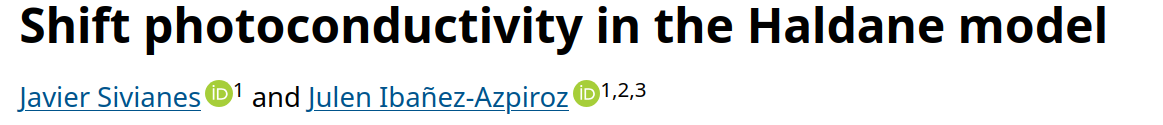

Paper by https://journals.aps.org/prb/abstract/10.1103/PhysRevB.108.155419 

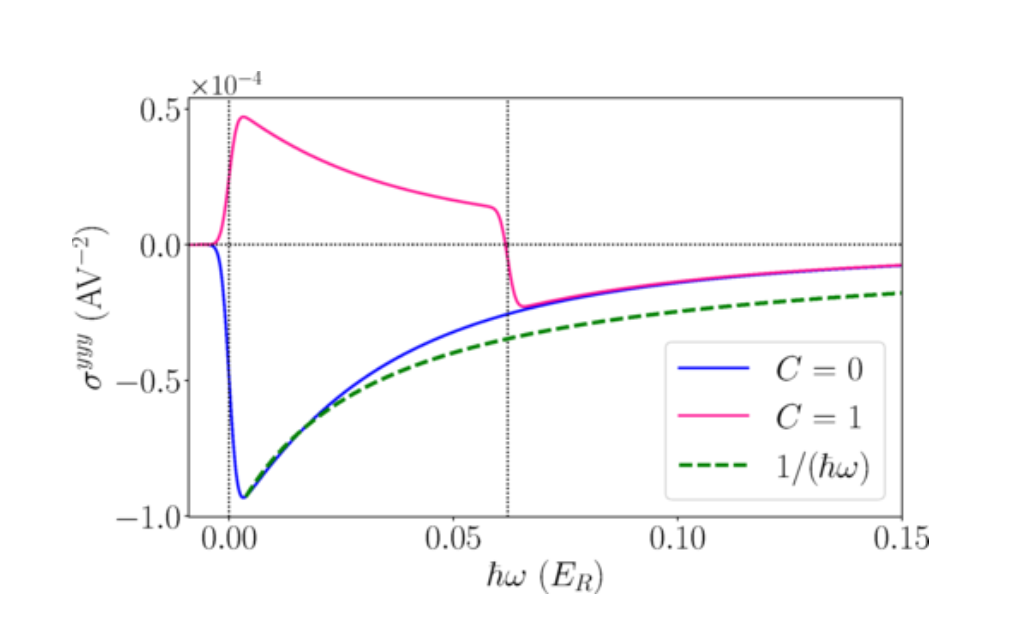

In [ ]:
def plot_data_BZ(data, basis, vmin=0, vmax=1, axes=None, to_BZ=True, return_vertices=False,
                 levels=None, nlevels=10):
    """
    Plot data, given on a regular grid in the reciprocal space, 
    in the first Brillouin zone of the reciprocal lattice.

    Parameters
    ----------
    data : 2D array
        The data to plot.
    basis : 2D array (2x2)
        The basis vectors of the reciprocal lattice.
    vmax : float
        The maximum value for the colormap.
    axes : matplotlib.axes.Axes
        The axes to plot on.
    to_BZ : bool
        If True, the data will be folded back into the first Brillouin zone. If False, the data will be plotted as is.
    """

    g1 = basis[0, :2]
    g2 = basis[1, :2]
    k1 = np.linspace(0, 1, data.shape[0], endpoint=False)
    k2 = np.linspace(0, 1, data.shape[1], endpoint=False)
    K1, K2 = np.meshgrid(k1, k2)
    KX = K1 * g1[0] + K2 * g2[0]
    KY = K1 * g1[1] + K2 * g2[1]
    if axes is None:
        axes = plt.gca()
    if to_BZ:
        for i in range(10):
            finish = True
            for direction in [(-1, 1), (0, 1), (1, 0), (1,1)]:
                direction_cart = basis[0, :2] * direction[0] + basis[1, :2] * direction[1]
                direction_cart_norm = direction_cart / np.linalg.norm(direction_cart) ** 2
                proj = KX * direction_cart_norm[0] + KY * direction_cart_norm[1]
                selection = proj > 0.5
                if np.any(selection):
                    finish = False
                KX[selection] -= direction_cart[0]
                KY[selection] -= direction_cart[1]
                selection = proj < -0.5
                if np.any(selection):
                    finish = False
                KX[selection] += direction_cart[0]
                KY[selection] += direction_cart[1]
            if finish:
                break

    # Flatten the arrays for use with tricontourf or tripcolor
    KX_flat = KX.flatten()
    KY_flat = KY.flatten()
    jdos0_flat = data.flatten()

    # plt.figure(figsize=(8, 6))
    if levels is None:
        levels = np.linspace(vmin, vmax, nlevels)
    tricontour = axes.tricontourf(KX_flat, KY_flat, jdos0_flat, cmap='viridis',
                                  levels=levels,
                                  vmin=vmin, vmax=vmax)
    # print(f"tricontour : {dir(tricontour)}")
    # print(tricontour.levels)
    vertices = np.array(p.vertices for p in tricontour.get_paths())

    axes.set_xlabel('KX')
    axes.set_ylabel('KY')
    if return_vertices:
        return axes, vertices
    else:
        return axes

In [ ]:
from matplotlib import pyplot
fig, axes = pyplot.subplots(1, 1, figsize=(6, 6))
data = results_topo.results["tabulate"].get_data(quantity="berry", component="z")
data = data[:,:,0,0] # select the kz=0 and 0th band
data = data# convert to log scale
print (f"data.min: {data.min()}, data.max: {data.max()}")
plot_data_BZ(basis=system_haldane_topo.recip_lattice[:2,:2], data=data, vmax = 0.01, vmin = -4, nlevels=200 )


In [ ]:
system_haldane_topo.recip_lattice